In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV

from joblib import dump, load

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

/Users/jason/anaconda3/envs/insight/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/jason/anaconda3/envs/insight/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/jason/anaconda3/envs/insight/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
conn_dict = {'host': 'localhost',
        'dbname': 'insight',
        'user': os.getenv('PG_USER'),
        'password': os.getenv('PG_PASSWORD')}

In [3]:
with psycopg2.connect(**conn_dict) as conn, conn.cursor() as cur:
    cur.execute('SELECT * FROM patterns3')
    res = cur.fetchall()
    cols = [desc[0] for desc in cur.description]

In [4]:
DF = pd.DataFrame(res, columns=cols)


# EDA and Feature Eng.

In [5]:
df = DF.copy()

In [6]:
df.loc[:, 'price'] = df.price.apply(lambda x: float(x) if pd.notnull(x) else 0)

In [7]:
df.loc[:, 'pubyear'] = df.published.apply(lambda x: x.year if pd.notnull(x) else None)

In [8]:
df.loc[:, 'buttoned_mod'] = df[['attribute_buttoned', 'attribute_buttonholes']].max(axis=1)

In [9]:
attribute_cols = [a for a in df.columns if a.startswith('attribute_')]
att_df = df[attribute_cols].sum(axis=0).reset_index().sort_values(0, ascending=False)
att_df.columns = ['attribute', 'pattern_count']
att_df.loc[:, 'pattern_share'] = att_df.pattern_count / df.shape[0]
# att_df[att_df.pattern_share >= 0.05]

In [10]:
needles_cols = [n for n in df.columns if n.startswith('needles_')]
needle_df = df[needles_cols].sum(axis=0).reset_index().sort_values(0, ascending=False)
needle_df.columns = ['needle_size', 'pattern_count']
needle_df.loc[:, 'pattern_share'] = needle_df.pattern_count / df.shape[0]
# needle_df[needle_df.patte rn_share >= 0.01]


In [11]:
# numeric_cols = ['projects_count', 'queued_projects_count', 'rating_average','comments_count',
#                'difficulty_average','num_photos', 'author_pattern_count','author_favorites_count']
numeric_cols = ['difficulty_average','num_photos']

cat_cols = ['pattern_type','yarn_weight']


attribute_cols = ['buttoned_mod',
                  'attribute_adult', #
                  'attribute_female',#
                  'attribute_worked_flat',#
                  'attribute_worked_in_the_round',#
                  'attribute_chart',#
                  'attribute_bottom_up',#
                  'attribute_one_piece',#
                  'attribute_unisex',#
                  'attribute_seamed',#
                  'attribute_lace',#
                  'attribute_teen',#
                  'attribute_ribbed_ribbing',#
                  'attribute_textured',#
                  'attribute_cables',#
                  'attribute_stripes_colorwork',#
                  'attribute_top_down',#
                  'attribute_child',#
                  'attribute_long',#
                  'attribute_stranded',#
                  'attribute_baby',#
                  'attribute_positive_ease',#
                  'attribute_has_schematic',#
                  'attribute_male',#
                  'attribute_eyelets',#
                  'attribute_toddler', #
                  'attribute_fitted',#
                  'attribute_short_rows']

needles_cols = ['needles_us_6',
                'needles_us_7',
                'needles_us_4',
                'needles_us_8',
                'needles_us_5',
                'needles_us_3',
                'needles_us_2h',
                'needles_us_10',
                'needles_us_9',
                'needles_us_1h',
                'needles_us_2',
                'needles_us_1',
                'needles_us_11',
                'needles_us_10h',
                'needles_us_13',
                'needles_us_15',
                'needles_us_0']

bool_cols = needles_cols + attribute_cols

for cat_col in cat_cols:
    df.loc[:, cat_col] = df[cat_col].apply(lambda x: str(x))

for num_col in numeric_cols:
    df.loc[:, num_col] = df[num_col].apply(lambda x: float(x))

In [12]:
# Type cast variables 

df = df[['price'] + bool_cols + numeric_cols + cat_cols].dropna()



# Initial Pipeline

In [15]:
# df.isna().sum().reset_index().sort_values(0, ascending=False)

X = df[bool_cols + numeric_cols + cat_cols]
y = df.price.apply(lambda x: int(x > 0))  # is item for sale (1) or free (0)

print(f'Data is {X.shape[0]} rows and {X.shape[1]} cols')
print(f'{np.round(100*np.mean(y), 2)}% of patterns are free')

Data is 393467 rows and 49 cols
48.7% of patterns are free


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
print(f'Training data shape: {X_train.shape}')

Training data shape: (314773, 49)


### Elastic Net Logistic to predict free or not

In [22]:
cats = [list(set(X.pattern_type)),list(set(X.yarn_weight))]

preprocess = make_column_transformer(
    (StandardScaler(), numeric_cols + bool_cols),
    (OneHotEncoder(categories=cats), cat_cols))

sgd_params = dict(validation_fraction=0.1,
                  penalty='elasticnet',
                  loss='log',
                  random_state=42,
                  max_iter=10)

pipeline = make_pipeline(preprocess, SGDClassifier(**sgd_params))

%time pipeline.fit(X_train, y_train)
print("ElasticNet SGDClassifier regression score: %f" % pipeline.score(X_test, y_test))

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


CPU times: user 10.1 s, sys: 452 ms, total: 10.5 s
Wall time: 5.45 s
ElasticNet SGDClassifier regression score: 0.710691


/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


#### Get feature names and coefficients of the best model

In [23]:
standardscaler_features = preprocess.transformers_[0][2]
ohe_features = [cat_cols[i] + '_' + item for i, l in enumerate(preprocess.transformers_[1][1].categories) for item in l]
ftrs = standardscaler_features + ohe_features

coefs = pipeline.named_steps['sgdclassifier'].coef_[0]
model_results = pd.DataFrame({'feature': ftrs, 'coef': coefs}).sort_values('coef', ascending=True)

In [24]:
model_results[model_results.feature != 0]

,feature,coef
6,author_pattern_count,-0.746383
69,pattern_type_tube,-0.500186
80,yarn_weight_Aran / Worsted,-0.422263
89,yarn_weight_Thread,-0.316141
93,yarn_weight_DK / Sport,-0.270068
70,pattern_type_knee-highs,-0.268611
2,rating_average,-0.222216
3,comments_count,-0.221571
59,pattern_type_gloves,-0.203683
1,queued_projects_count,-0.180337


In [24]:
f1_score(y_test, pipeline.predict(X_test))

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


0.7042945121867585

# Second stage model to predict price for sale items

In [13]:
df2 = DF[(DF.currency == 'USD') & \
             (DF.price <= 17) & \
             (DF.price > 0) & \
             pd.notnull(DF.price)]

df2.loc[:, 'buttoned_mod'] = df2[['attribute_buttoned', 'attribute_buttonholes']].max(axis=1)
df2.loc[:, 'price'] = df2.price.apply(lambda x: float(x) if pd.notnull(x) else 0)

for cat_col in cat_cols:
    df2.loc[:, cat_col] = df2[cat_col].apply(lambda x: str(x))

for num_col in numeric_cols + ['price']:
    df2.loc[:, num_col] = df2[num_col].apply(lambda x: float(x))

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
#fig, ax = plt.subplots()
#fig.set_size_inches(12,8)
#plt.hist(df2.price)
#ax.set_yscale('log')
#ax.set_xlabel("Price ($)")
#ax.set_ylabel("# Patterns for sale")
#ax.set_title('Distribution of Individual Pattern Prices')

In [20]:
#df2.pattern_type.value_counts().reset_index()

In [14]:
df2 = df2[['price']+ bool_cols + numeric_cols + cat_cols].dropna()
y2 = df2.price
X2 = df2[bool_cols + numeric_cols + cat_cols]
X2_train, X2_test, y2_train, y2_test = \
train_test_split(X2, y2, test_size=0.2, random_state=42)

### Random Forest Regression

In [15]:
cats = [list(set(X2.pattern_type)),list(set(X2.yarn_weight))]

preprocess = make_column_transformer(
    (StandardScaler(), numeric_cols + bool_cols),
    (OneHotEncoder(categories=cats), cat_cols))

rf_pipe = make_pipeline(preprocess, RandomForestRegressor(random_state=42, n_estimators=100))
%time rf_pipe.fit(X2_train, y2_train)

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


CPU times: user 1min 36s, sys: 427 ms, total: 1min 37s
Wall time: 1min 35s


Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), ['difficulty_average', 'num_photos', 'needles_us_6', 'needles_us_...mators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [16]:
from sklearn.metrics import median_absolute_error

print(f"MSE Test: {np.sqrt(mean_squared_error(y2_train, rf_pipe.predict(X2_train)))}")
print(f"MAE Test: {median_absolute_error(y2_test, rf_pipe.predict(X2_test))}")

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


MSE Test: 0.5611146768149698


/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


MAE Test: 0.7520999999999987


In [17]:
#dump(rf_pipe, 'stage2_reduced_v0.joblib')

['stage2_reduced_v0.joblib']

## Validation curves

In [27]:
from sklearn.model_selection import validation_curve

param_range = np.arange(2, 15)
train_scores, test_scores = validation_curve(
    rf_pipe, X2, y2, param_name="randomforestregressor__max_depth", param_range=param_range,
    cv=5, scoring="neg_median_absolute_error", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-pa

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-pa

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-pa

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-pa

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-pa

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-pa

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-pa

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-pa

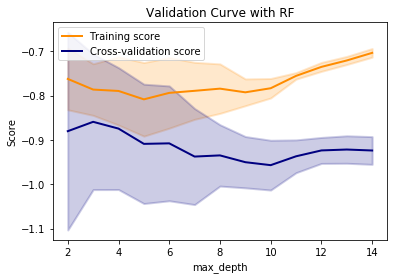

In [28]:
plt.title("Validation Curve with RF")
plt.xlabel(r"max_depth")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Benchmark: category means

In [28]:
z = df2.groupby('pattern_type').agg({'price': 'median'}).reset_index()
median_map = dict(zip(z.pattern_type, z.price))
X2_test.loc[:, 'cat_mean'] = X2.pattern_type.apply(lambda x: median_map[x])

In [32]:
median_absolute_error(y2_test, X2_test.cat_mean)
#np.sqrt(mean_squared_error(y2_test, X2_test.cat_mean))

1.0

In [21]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

# RF without numeric values? 

In [15]:
df2 = DF[(DF.currency == 'USD') & \
             (DF.price <= 17) & \
             (DF.price > 0) & \
             pd.notnull(DF.price)]

df2.loc[:, 'buttoned_mod'] = df2[['attribute_buttoned', 'attribute_buttonholes']].max(axis=1)
df2.loc[:, 'price'] = df2.price.apply(lambda x: float(x) if pd.notnull(x) else 0)

for cat_col in cat_cols:
    df2.loc[:, cat_col] = df2[cat_col].apply(lambda x: str(x))

for num_col in numeric_cols + ['price']:
    df2.loc[:, num_col] = df2[num_col].apply(lambda x: float(x))

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
df2 = df2[['price']+ bool_cols + cat_cols + ['num_photos']].dropna()
y2 = df2.price
X2 = df2[bool_cols + cat_cols + ['num_photos']]
X2_train, X2_test, y2_train, y2_test = \
train_test_split(X2, y2, test_size=0.2, random_state=42)

In [18]:
cats = [list(set(X2.pattern_type)),list(set(X2.yarn_weight))]

preprocess = make_column_transformer(
    (StandardScaler(), ['num_photos'] + bool_cols),
    (OneHotEncoder(categories=cats), cat_cols))

rf_pipe = make_pipeline(preprocess, RandomForestRegressor(random_state=42, n_estimators=100))
%time rf_pipe.fit(X2_train, y2_train)

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


CPU times: user 1min 34s, sys: 506 ms, total: 1min 34s
Wall time: 1min 32s


Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True), ['num_photos', 'needles_us_6', 'needles_us_7', 'needles_us_4', 'n...mators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [19]:
print(f"MSE Train: {mean_squared_error(y2_train, rf_pipe.predict(X2_train))}")
print(f"MSE Test: {mean_squared_error(y2_test, rf_pipe.predict(X2_test))}")

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


MSE Train: 0.3441611291692491


/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


MSE Test: 2.077400992906812
